In [18]:
import pandas as pd
import numpy as np

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Optional, Tuple

import muspy

In [19]:
PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "essen"
DATA_ROOT.mkdir(parents=True, exist_ok=True)

ds = muspy.datasets.EssenFolkSongDatabase(
    root=Path("data/essen"),
    download_and_extract=True,
    convert=False, 
    use_converted=None,
    verbose=True,
    n_jobs=-1
)

Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.


In [20]:
print("Песен:", len(ds))

Песен: 10457


In [21]:
def music_to_tokens(music: muspy.Music, step_division: int = 8):

    step_ticks = max(1, int(music.resolution) // step_division)
    tracks = [t for t in music.tracks if t.notes]
    track = max(tracks, key=lambda t: len(t.notes))

    notes = sorted(track.notes, key=lambda n: n.time)

    tokens = []
    prev_end = 0

    for n in notes:
        rest_ticks = max(0, int(n.time) - int(prev_end))

        rest = int(np.round(rest_ticks / step_ticks)) # это пауза перед нотой в шагах
        dur = max(1, int(np.round(int(n.duration) / step_ticks))) # это длительность ноты в шагах
        pitch = int(n.pitch) # это значение MIDI ноты (от 0 до 127)

        tokens.append((pitch, dur, rest))
        prev_end = max(prev_end, int(n.time) + int(n.duration)) 

    return tokens

In [22]:
import json

with open("data/essen_tokens.jsonl", "r", encoding="utf-8") as f:
    first = json.loads(f.readline())

print("Первые 10 токенов:", first[:10])
print("Длина:", len(first))

Первые 10 токенов: [[69, 8, 0], [69, 8, 0], [69, 8, 0], [69, 8, 0], [71, 8, 0], [72, 8, 0], [69, 8, 0], [69, 16, 0], [72, 8, 8], [73, 8, 0]]
Длина: 104


In [23]:
songs = []
for i in range (1000, 2000, 1):
    try:
        music = ds[i]
    except: 
        continue
    music = ds[i]
    tokens = music_to_tokens(music)
    songs.append(tokens)

print("Количество песен:", len(songs))

C:\Users\yaros\AppData\Roaming\Python\Python313\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Количество песен: 1000


In [24]:
songs = list(filter(lambda x: len(x) >= 30, songs))
print("Песен для обучения:", len(songs))

Песен для обучения: 769


In [25]:
from collections import defaultdict, Counter

def make_markov_chain(songs):
    transitions = defaultdict(Counter) # матрица переходов
    starts = Counter()

    for tokens in songs:
        starts[tokens[0]] += 1
        for a, b in zip(tokens, tokens[1:]):
            transitions[a][b] += 1

    return starts, transitions


In [26]:
import random

def sample_from_counter(counter: Counter):
    items = list(counter.items())

    states, weights = [], []
    for s, w in items:
        states.append(s)
        weights.append(w)
    sum_weights = sum(weights)

    return random.choices(states, weights=np.array(weights)/sum_weights)[0]

def create_melody(starts, trans, length=200):
    cur = sample_from_counter(starts)
    out = [cur]
    for _ in range(length - 1):
        if len(trans[cur]) == 0:
            cur = sample_from_counter(starts)
        else:
            cur = sample_from_counter(trans[cur])
        out.append(cur)
    return out


In [27]:
starts, trans = make_markov_chain(songs)
gen_tokens = create_melody(starts, trans, length=200)

print("Сгенерировано токенов:", len(gen_tokens))
print("Первые 10:", gen_tokens[:10])

Сгенерировано токенов: 200
Первые 10: [(62, 8, 0), (69, 8, 0), (69, 4, 0), (74, 4, 0), (74, 2, 0), (74, 4, 0), (69, 4, 0), (69, 8, 0), (66, 4, 8), (64, 8, 0)]


In [28]:
import muspy

def tokens_to_midi(tokens, out_midi="markov.mid", resolution=480, step_division=8, program=102):
    step_ticks = resolution // step_division
    music = muspy.Music(resolution=resolution)
    track = muspy.Track(program=program)
    music.tracks.append(track)

    t = 0
    for pitch, dur, rest in tokens:
        t += int(rest) * step_ticks
        track.notes.append(muspy.Note(time=t, pitch=int(pitch), duration=int(dur) * step_ticks, velocity=80))
        t += int(dur) * step_ticks

    muspy.write_midi(out_midi, music)
    return out_midi

tokens_to_midi(gen_tokens, "markov.mid")


'markov.mid'

In [29]:
def create_cyclic_melody(starts, trans, length=10, repetitions=10, name="markov_cyclic.mid", program=102):
    sample = create_melody(starts, trans, length=length)
    cyclic = sample * repetitions
    tokens_to_midi(cyclic, name, program=program)

def get_cyclic_tokens(starts, trans, length=10, repetitions=10):
    sample = create_melody(starts, trans, length=length)
    cyclic = sample * repetitions
    return cyclic

In [30]:
create_cyclic_melody(starts, trans, length=8, repetitions=10, name="markov_cyclic.mid", program=10)

In [31]:
import muspy

def tokens_to_midi_two_tracks(
    melody_tokens,
    resolution=480,
    step_division=4,
    melody_program=0,
    acc_program=0,
    name="two_tracks.mid"
):
    step_ticks = resolution // step_division

    music = muspy.Music(resolution=resolution)

    melody = muspy.Track(program=melody_program)
    acc = muspy.Track(program=acc_program)

    music.tracks.append(melody)
    music.tracks.append(acc)

    t = 0
    for pitch, dur, rest in melody_tokens:
        t += int(rest) * step_ticks
        dur_ticks = max(1, int(dur) * step_ticks)
        melody.notes.append(muspy.Note(time=t, pitch=int(pitch), duration=dur_ticks, velocity=90)) # это генерация основной мелодии

        # генерация аккомпанемента (триада, что бы это ни значило...), мажорный аккорд
        root = int(pitch) - 24                 # бас на 2 октавы ниже
        third = int(pitch) - 12 + 4            # мажорная терция
        fifth = int(pitch) - 12 + 7            # квинта

        for p in (root, third, fifth):
            if 0 <= p <= 127:
                acc.notes.append(muspy.Note(time=t, pitch=p, duration=dur_ticks, velocity=60))

        t += dur_ticks

    muspy.write_midi(name, music)
    return name

tokens_to_midi_two_tracks(gen_tokens, melody_program=0, acc_program=32)

'two_tracks.mid'

In [32]:
cyclic_acc_tokens = get_cyclic_tokens(starts, trans, length=10, repetitions=10)
tokens_to_midi_two_tracks(
    cyclic_acc_tokens,
    melody_program=0,
    acc_program=0,
    step_division=6,
    name="markov_cyclic_two_tracks_2.mid"
)

'markov_cyclic_two_tracks_2.mid'

In [33]:
import random
from collections import Counter

def top_k_states_from_trans(trans, k=8):
    state_freq = Counter()
    for s, cnt in trans.items():
        state_freq[s] += sum(cnt.values())
    return [s for s, _ in state_freq.most_common(k)]

def random_states_from_trans(trans, k=8, seed=42):
    random.seed(seed)
    states = list(trans.keys())
    return random.sample(states, k)


In [34]:
from matplotlib import pyplot as plt


def build_transition_matrix(trans, states):
    idx = {s: i for i, s in enumerate(states)}
    n = len(states)
    M = np.zeros((n, n), dtype=float)

    for s_from in states:
        row = trans.get(s_from, None)
        total = sum(row.values())

        i = idx[s_from]
        for s_to, c in row.items():
            if s_to in idx:
                j = idx[s_to]
                M[i, j] = c / total
    return M


def plot_transition_matrix(M, states, title=""):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    im = ax.imshow(M)
    fig.colorbar(im, ax=ax, rotation='vertical')

    ax.set_title(title)

    labels = [str(s) for s in states]
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    plt.tight_layout()
    plt.show()


In [ ]:
states_top50 = top_k_states_from_trans(trans, k=50)
M_top50 = build_transition_matrix(trans, states_top50)
plot_transition_matrix(M_top50, states_top50, title="Матрица переходов (топ 50 состояний)")

In [ ]:
def self_similarity_midi_ticks(
    midi_path: str
):
    music = muspy.read_midi(midi_path)
    resolution = int(music.resolution)
    window_ticks = 4 * resolution

    notes = []
    tracks = music.tracks

    for tr in tracks:
        for n in tr.notes:
            notes.append((int(n.time), int(n.duration), int(n.pitch)))

    max_tick = max(t + d for t, d, _ in notes)
    n_windows = int(np.ceil(max_tick / window_ticks))
    chroma = np.zeros((n_windows, 12), dtype=float)

    for t, d, p in notes:
        start_w = t // window_ticks
        end_w = (t + d) // window_ticks
        pc = p % 12

        for w in range(start_w, min(end_w + 1, n_windows)):
            chroma[w, pc] += d

    norms = np.linalg.norm(chroma, axis=1, keepdims=True)
    chroma = chroma / np.maximum(norms, 1e-12)

    S = chroma @ chroma.T
    
    plt.figure()
    plt.imshow(S, origin="lower", aspect="auto")
    plt.colorbar()
    plt.title(f"Матрица самоподобия — {Path(midi_path).name}")
    plt.tight_layout()
    plt.show()

    return S


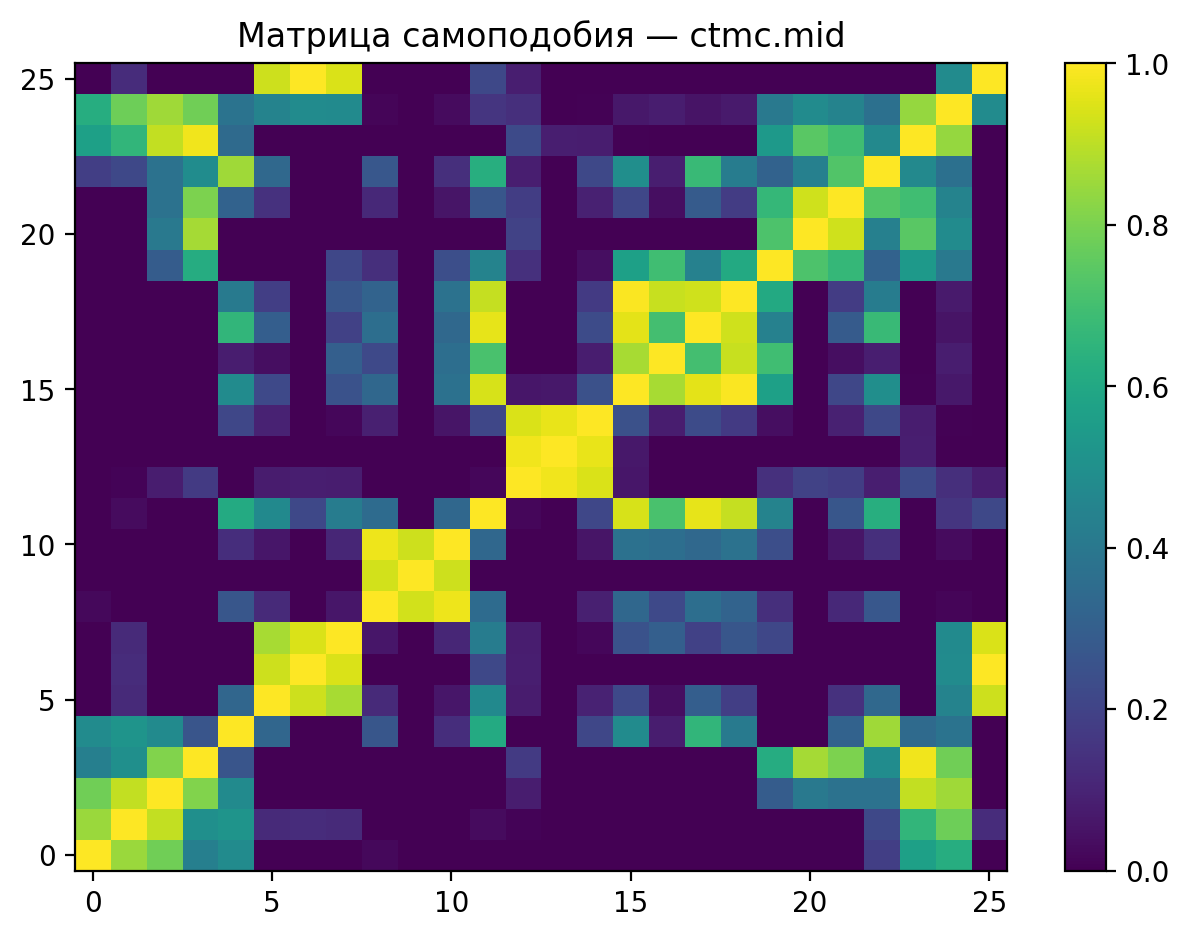

In [55]:
S = self_similarity_midi_ticks("base_melodies_by_yara/ctmc.mid")

In [48]:
REST = 128 # пустой звук

def tokens_to_state_durations(tokens):
    seq = []
    for t in tokens:
        pitch, dur, rest = t
        if rest > 0:
            seq.append((REST, int(rest)))
        seq.append((int(pitch), int(dur)))
    return seq


In [49]:
def make_continuous_time_markov_chain(songs_tokens):

    start_counts = Counter()
    T = Counter()
    N = defaultdict(Counter)

    for t in songs_tokens:
        seq = tokens_to_state_durations(t)
        start_counts[seq[0][0]] += 1

        for s, dt in seq:
            if dt > 0:
                T[s] += dt

        for (s1, _), (s2, _) in zip(seq, seq[1:]):
            N[s1][s2] += 1

    # интенсивность считаю как q_ij = N_ij / T_i (то есть количество переходов определённого вида на единицу времени)
    Q = {}
    for i, counter in N.items():
        Ti = T[i]
        Q[i] = {j: cnt / Ti for j, cnt in counter.items() if j != i}

    return start_counts, T, N, Q


In [53]:
def generate_ctmc(start_counts, Q, total_time=400, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    cur = sample_from_counter(start_counts)
    out = []
    t = 0

    while t < total_time:
        if cur not in Q or len(Q[cur]) == 0:
            cur = sample_from_counter(start_counts)
            continue

        lam = sum(Q[cur].values())
        if lam <= 0:
            cur = sample_from_counter(start_counts)
            continue
        # время ожидания в текущем состоянии ~ Exp(lam)
        dt = np.random.exponential(scale=1.0 / lam)
        dt_steps = max(1, int(round(dt)))  # хотя бы 1 шаг

        out.append((cur, dt_steps))
        t += dt_steps
        if t >= total_time:
            break

        # выбираем следующее состояние пропорционально интенсивностям
        next_states = list(Q[cur].keys())
        rates = np.array([Q[cur][j] for j in next_states], dtype=float)
        probs = rates / rates.sum()
        cur = np.random.choice(next_states, p=probs)

    return out


In [54]:
import muspy

def ctmc_to_midi(seq, out_midi="ctmc.mid", resolution=480, step_division=4):
    step_ticks = resolution // step_division
    music = muspy.Music(resolution=resolution)
    track = muspy.Track(program=0)
    music.tracks.append(track)

    t_ticks = 0
    for state, dur_steps in seq:
        dur_ticks = max(1, int(dur_steps) * step_ticks)
        if state == REST:
            t_ticks += dur_ticks
        else:
            track.notes.append(muspy.Note(time=t_ticks, pitch=int(state), duration=dur_ticks, velocity=80))
            t_ticks += dur_ticks

    muspy.write_midi(out_midi, music)
    return out_midi


In [52]:
start_counts, T, N, Q = make_continuous_time_markov_chain(songs)
seq = generate_ctmc(start_counts, Q, total_time=400, seed=0)
ctmc_to_midi(seq, "ctmc_markov_2.mid")


'ctmc_markov_2.mid'